In [32]:
import random

class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else:
            return Sentiment.POSITIVE
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
    
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        neutral = list(filter(lambda x: x.sentiment == Sentiment.NEUTRAL, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        neutral_shrunk = neutral[:len(negative)]
        self.reviews = negative + positive_shrunk + neutral_shrunk
        random.shuffle(self.reviews)

### Load data

In [33]:
import json

file_name ="./Books_small_10000.json"

reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review["reviewText"], review["overall"]))
        
reviews[5].text


'I hoped for Mia to have some peace in this book, but her story is so real and raw.  Broken World was so touching and emotional because you go from Mia\'s trauma to her trying to cope.  I love the way the story displays how there is no "just bouncing back" from being sexually assaulted.  Mia showed us how those demons come for you every day and how sometimes they best you. I was so in the moment with Broken World and hurt with Mia because she was surrounded by people but so alone and I understood her feelings.  I found myself wishing I could give her some of my courage and strength or even just to be there for her.  Thank you Lizzy for putting a great character\'s voice on a strong subject and making it so that other peoples story may be heard through Mia\'s.'

### Prep data

In [34]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(training)
train_container.evenly_distribute()

test_container = ReviewContainer(test)
test_container.evenly_distribute()


In [35]:
# train_x = [x.text for x in training]
# train_y = [x.sentiment for x in training]

train_x = train_container.get_text()
train_y = train_container.get_sentiment()

# test_x = [x.text for x in test]
# test_y = [x.sentiment for x in test]

test_x = test_container.get_text()
test_y = test_container.get_sentiment()


### Bag of words

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tfidvectorizer = term frecuency inverse document frecuency

vectorizer = TfidfVectorizer()

train_x_vectors = vectorizer.fit_transform(train_x)

# The same but in two lines
# vectorizer.fit(train_x)
# train_x_vectors = vectorizer.transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

### Classifications

#### Linear SVM

In [37]:
from sklearn import svm

clf_svm = svm.SVC(kernel="linear")

clf_svm.fit(train_x_vectors, train_y)

clf_svm.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

#### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

array(['NEUTRAL'], dtype='<U8')

#### Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
clf_gnb.fit(train_x_vectors.toarray(), train_y)

clf_gnb.predict(test_x_vectors[0].toarray())

array(['NEGATIVE'], dtype='<U8')

#### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(solver='lbfgs', multi_class="auto")
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

### Evaluation
#### Mean accuracy

In [46]:
clf_svm.score(test_x_vectors, test_y)

0.6169871794871795

In [47]:
clf_dec.score(test_x_vectors, test_y)

0.4182692307692308

In [48]:
clf_gnb.score(test_x_vectors.toarray(), test_y)

0.4342948717948718

In [49]:
clf_log.score(test_x_vectors, test_y)

0.6217948717948718

#### F1 Scores

In [50]:
from sklearn.metrics import f1_score

print(f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE]))
print(f1_score(test_y, clf_dec.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE]))
print(f1_score(test_y, clf_gnb.predict(test_x_vectors.toarray()), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE]))
print(f1_score(test_y, clf_log.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE]))

[0.69417476 0.5450237  0.61352657]
[0.44819277 0.36626506 0.44019139]
[0.46786632 0.40089087 0.43902439]
[0.70117647 0.5410628  0.62102689]


In [53]:
test_set = ["The funniest book i have ever read, 0 stars", 
            "The funniest book i have ever read, 5 stars", 
            "Really bad, 5 stars", 
            "Really bad, 0 stars",
            "Dont buy it", 
            "Meh"]

# "Meh" test is really interesting

new_test = vectorizer.transform(test_set)

clf_svm.predict(new_test)

array(['POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE',
       'NEUTRAL'], dtype='<U8')

### Tuning our model (with grid search)

In [54]:
from sklearn.model_selection import GridSearchCV

parameters = {"kernel": ("linear", "rbf"), "C": (1,2,4,8,16,32)}

svc = svm.SVC(gamma="auto")

clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': (1, 2, 4, 8, 16, 32),
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [55]:
clf.score(test_x_vectors, test_y)

0.6169871794871795

### Confusion matrix

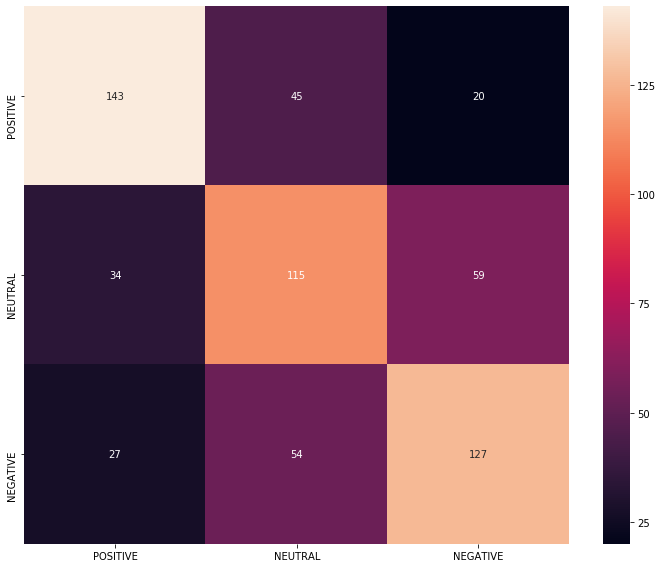

In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

y_pred = clf.predict(test_x_vectors)

labels = [Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(10, 8)) 

sn.heatmap(df_cm, annot=True, fmt='d', ax=ax)

ax.set_ylim(0,3)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show(train_x_vectors)


### PCA

Singular values:  [4.13052965 3.24196049 2.95988017]
Variance ratio:  [0.01413884 0.00870999 0.00726024]
(1308, 3)


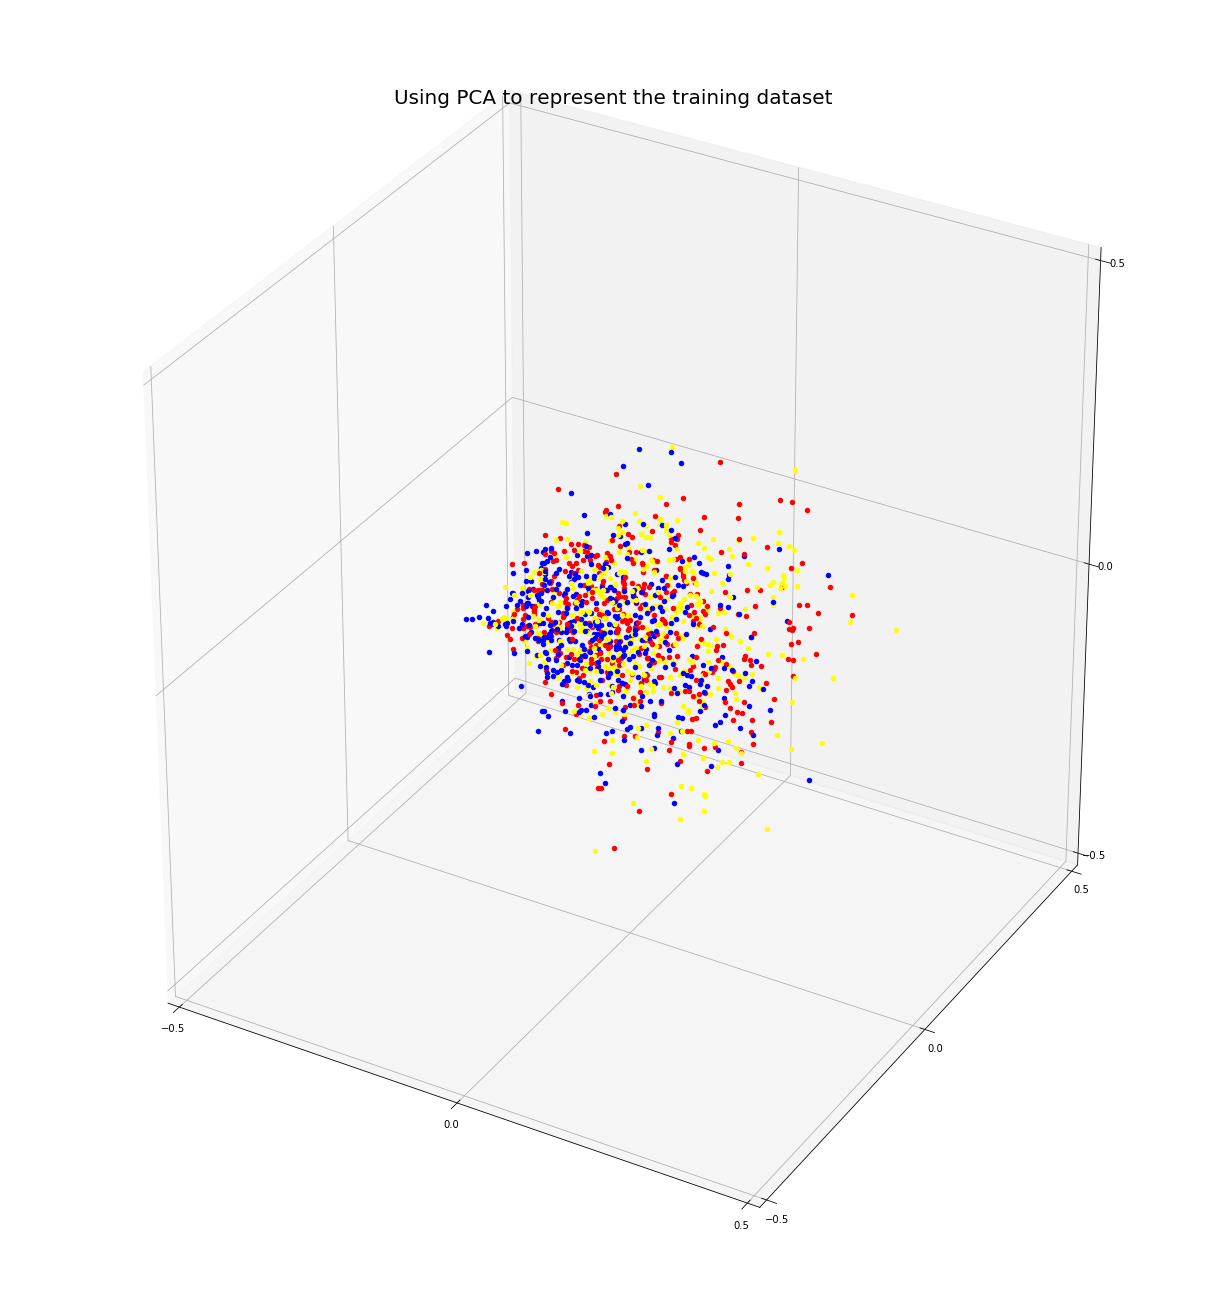

In [144]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

pca = PCA(n_components=3)
p = pca.fit_transform(train_x_vectors.toarray())

print("Singular values: ", pca.singular_values_)
print("Variance ratio: ", pca.explained_variance_ratio_)

fig2 = plt.figure(342, figsize=(100,80))
ax = fig2.add_subplot(342, projection='3d')

print(p.shape)
i = 0
for x,y,z in p:
    if train_y[i] == Sentiment.POSITIVE:
        ax.scatter(x,y,z, 'o', color='blue')
    elif train_y[i] == Sentiment.NEGATIVE:
        ax.scatter(x,y,z, '^', color='red')
    else:
        ax.scatter(x,y,z, 's', color='yellow')
    i+=1
    
ax.set_zticks(np.linspace(-0.5, 0.5, 3))
ax.set_xticks(np.linspace(-0.5, 0.5, 3))
ax.set_yticks(np.linspace(-0.5, 0.5, 3))

plt.title("Using PCA to represent the training dataset", fontdict={"fontsize": 20})
plt.show()

### Saving Model

In [145]:
import pickle

with open("./models/sentiment_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)

In [146]:

with open("./models/sentiment_classifier.pkl", "rb") as f:
    loaded_clf = pickle.load(f)

print(test_x[0])
loaded_clf.predict(test_x_vectors[0])

Seriously, pick a guy!  And grandma mazur hasnt kicked the bucket yet?  The books get shorter and shorter, and the plots are getting close to being re-used.  I might be done.


array(['POSITIVE'], dtype='<U8')